Import libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
import matplotlib.pyplot as plt
import pickle
import json
from PIL import Image
import pandas as pd
import os
import numpy as np
import cv2



DataSet

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls "/content/drive/MyDrive"


'Colab Notebooks'  'Image Caption generation'


In [4]:
import os

dataset_path = '/content/drive/MyDrive/Image Caption generation/DataSet'

# List the contents of dataset folder
print("Dataset folder contents:", os.listdir(dataset_path))

# Set correct paths
image_folder = os.path.join(dataset_path, 'Images')
caption_file = os.path.join(dataset_path, 'captions.txt')

# Verify the files exist
print("Images folder contains:", len(os.listdir(image_folder)), "files")
print("First 5 images:", os.listdir(image_folder)[:5])
print("Captions file exists:", os.path.isfile(caption_file))


Dataset folder contents: ['captions.txt', 'Images', 'tokenizer.pkl', 'features.pkl']
Images folder contains: 2372 files
First 5 images: ['2269795781_46a296aa21.jpg', '226607225_44d696db6b.jpg', '2271755053_e1b1ec8442.jpg', '2278776373_fe499a93be.jpg', '2279496715_8ef3ee6edb.jpg']
Captions file exists: True


Preprocessing Captions

In [5]:
import string

# Load captions file
with open(caption_file, 'r') as f:
    captions_doc = f.read()

# Create dictionary mapping image names to their captions
captions_dict = {}

for line in captions_doc.strip().split('\n'):
    if len(line) < 1:
        continue
    img_cap_pair = line.split('\t')
    if len(img_cap_pair) == 1:
        img_cap_pair = line.split(' ')
        img_name = img_cap_pair[0].split('#')[0]
        caption = ' '.join(img_cap_pair[1:])
    else:
        img_name, caption = img_cap_pair
    img_name = img_name.split('#')[0]
    caption = caption.lower()
    caption = caption.translate(str.maketrans('', '', string.punctuation))
    caption = '<start> ' + caption + ' <end>'
    if img_name not in captions_dict:
        captions_dict[img_name] = []
    captions_dict[img_name].append(caption)

# Show example output
for img, caps in list(captions_dict.items())[:1]:
    print("Image:", img)
    print("Captions:")
    for c in caps:
        print("-", c)

Image: image,caption
Captions:
- <start>  <end>


Tokenizing Captions

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle

# Gather all captions into a list
all_captions = []
for key in captions_dict:
    all_captions.extend(captions_dict[key])

# Initialize the tokenizer and fit on captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size:", vocab_size)

# Save the tokenizer for later use
tokenizer_path = '/content/drive/MyDrive/Image Caption generation/DataSet/tokenizer.pkl'
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)

print(f"Tokenizer saved at: {tokenizer_path}")


Vocabulary size: 8746
Tokenizer saved at: /content/drive/MyDrive/Image Caption generation/DataSet/tokenizer.pkl


Find Maximum Caption Length

In [7]:
# Find the maximum length among all captions
max_length = max(len(c.split()) for c in all_captions)

print("Maximum caption length:", max_length)


Maximum caption length: 37


Extracting Image Features

In [8]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import numpy as np
import pickle
import os

# Load the InceptionV3 model without the final classification layer
base_model = InceptionV3(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

# Path to images folder
image_folder = '/content/drive/MyDrive/Image Caption generation/DataSet/Images'

# Dictionary to hold image features
features = {}

# Process and extract features for each image
for img_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, img_name)
    # Load the image with target size expected by InceptionV3
    image = load_img(img_path, target_size=(299, 299))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    # Extract features
    feature = model.predict(image, verbose=0)
    features[img_name] = feature

# Save the features to a file
features_path = '/content/drive/MyDrive/Image Caption generation/DataSet/features.pkl'
with open(features_path, 'wb') as f:
    pickle.dump(features, f)

print(f"Extracted features for {len(features)} images and saved to {features_path}")


96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Extracted features for 2372 images and saved to /content/drive/MyDrive/Image Caption generation/DataSet/features.pkl


Create a Data Generator

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Load the saved features
features_path = '/content/drive/MyDrive/Image Caption generation/DataSet/features.pkl'
with open(features_path, 'rb') as f:
    features = pickle.load(f)

# Load the saved tokenizer
tokenizer_path = '/content/drive/MyDrive/Image Caption generation/DataSet/tokenizer.pkl'
with open(tokenizer_path, 'rb') as f:
    tokenizer = pickle.load(f)

# Set the maximum caption length (as previously computed)
max_length = 35  # Replace this with the actual max_length you found

# Define the data generator
def data_generator(captions_dict, features, tokenizer, max_length, batch_size=32):
    image_names = list(captions_dict.keys())
    num_images = len(image_names)
    while True:
        for i in range(0, num_images, batch_size):
            batch_image_names = image_names[i:i+batch_size]
            X1, X2, y = [], [], []
            for img_name in batch_image_names:
                img_feature = features[img_name][0]  # Shape correction
                for caption in captions_dict[img_name]:
                    seq = tokenizer.texts_to_sequences([caption])[0]
                    for j in range(1, len(seq)):
                        in_seq, out_seq = seq[:j], seq[j]
                        in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                        out_seq = np.zeros(tokenizer.num_words)
                        out_seq[out_seq] = 1
                        X1.append(img_feature)
                        X2.append(in_seq)
                        y.append(out_seq)
            yield ([np.array(X1), np.array(X2)], np.array(y))


Build the Image Captioning Model

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

# Vocabulary size and maximum caption length from previous steps
vocab_size = len(tokenizer.word_index) + 1
max_length = 35  # Use the value you calculated earlier

# Image feature input
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence input (captions)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# Combine image and caption features
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Define the final model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 35, 256)   │  2,238,976 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 35, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 35)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8746)      │  2,247,722 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,602,346 (21.37 MB)

 Trainable params: 5,602,346 (21.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the Model

In [6]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 37)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 37, 256)   │  2,238,976 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 2048)      │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 37, 256)   │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 37)        │          0 │ input_layer_3[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    524,544 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    525,312 │ dropout_3[0][0],  │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ dense_3[0][0],    │
│                     │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     65,792 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8746)      │  2,247,722 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,602,346 (21.37 MB)

 Trainable params: 5,602,346 (21.37 MB)

 Non-trainable params: 0 (0.00 B)

Save the trained model and related files

In [7]:
import pickle
import json
import os

# Define paths
dataset_path = '/content/drive/MyDrive/Image Caption generation/DataSet'
model_path = os.path.join(dataset_path, 'image_caption_model.h5')
tokenizer_path = os.path.join(dataset_path, 'tokenizer.pkl')
config_path = os.path.join(dataset_path, 'config.json')

# Save the trained model
model.save(model_path)
print("Model saved at", model_path)

# Save the tokenizer
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)
print("Tokenizer saved at", tokenizer_path)

# Save max_length to a config file
with open(config_path, 'w') as f:
    json.dump({'max_length': max_length}, f)
print("Config saved at", config_path)


Model saved at /content/drive/MyDrive/Image Caption generation/DataSet/image_caption_model.h5
Tokenizer saved at /content/drive/MyDrive/Image Caption generation/DataSet/tokenizer.pkl
Config saved at /content/drive/MyDrive/Image Caption generation/DataSet/config.json


Load the model and files for generating captions

In [16]:
import os
import pickle
import json
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
import tensorflow as tf # Import tensorflow
from tensorflow.keras.utils import custom_object_scope # Import custom_object_scope

# Define paths to your dataset files
dataset_path = '/content/drive/MyDrive/Image Caption generation/DataSet'
model_path = os.path.join(dataset_path, 'image_caption_model.h5')
tokenizer_path = os.path.join(dataset_path, 'tokenizer.pkl')
config_path = os.path.join(dataset_path, 'config.json')
features_path = os.path.join(dataset_path, 'features.pkl')

# Load the tokenizer
with open(tokenizer_path, 'rb') as f:
    tokenizer = pickle.load(f)
print("Tokenizer loaded from", tokenizer_path)

# Load max_length from config file
with open(config_path, 'r') as f:
    config = json.load(f)
max_length = config['max_length']
print("Max length loaded:", max_length)

# Load image features
with open(features_path, 'rb') as f:
    features = pickle.load(f)
print("Image features loaded from", features_path)

# Rebuild the model architecture
vocab_size = len(tokenizer.word_index) + 1

# Image feature input
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence input (captions)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# Combine image and caption features
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Define the final model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# Load the weights from the saved model file
model.load_weights(model_path)

print("Model architecture rebuilt and weights loaded from", model_path)

Tokenizer loaded from /content/drive/MyDrive/Image Caption generation/DataSet/tokenizer.pkl
Max length loaded: 37
Image features loaded from /content/drive/MyDrive/Image Caption generation/DataSet/features.pkl
Model architecture rebuilt and weights loaded from /content/drive/MyDrive/Image Caption generation/DataSet/image_caption_model.h5


Generate Captions for Images

In [17]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_caption(model, tokenizer, photo_feature, max_length):
    in_text = '<start>'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

        # Predict the next word
        yhat = model.predict([photo_feature.reshape(1,2048), sequence], verbose=0)
        yhat = np.argmax(yhat)

        # Map the predicted index back to a word
        word = None
        for w, index in tokenizer.word_index.items():
            if index == yhat:
                word = w
                break

        if word is None:
            break

        in_text += ' ' + word

        if word == '<end>':
            break

    return in_text


Choose an image and generate its caption

Generated caption:
weights weights weights weights weights weights weights weights weights weights weights weights weights weights weights weights weights weights weights weights weights weights weights weights weights weights weights weights weights weights weights weights weights weights weights weights weights


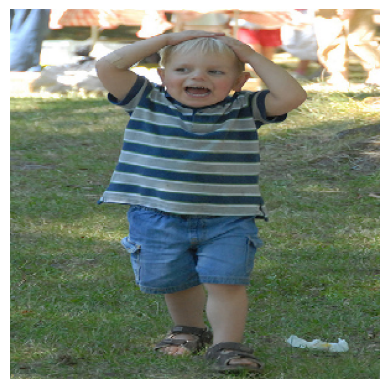

In [18]:
import random
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Pick a random image from the features dictionary
image_name = random.choice(list(features.keys()))
photo_feature = features[image_name][0]

# Generate the caption
caption = generate_caption(model, tokenizer, photo_feature, max_length)
print("Generated caption:")
print(caption.replace('<start>', '').replace('<end>', '').strip())

# Display the image
img_path = os.path.join(dataset_path, 'Images', image_name)
img = load_img(img_path, target_size=(299, 299))
plt.imshow(img)
plt.axis('off')
plt.show()
